In [4]:
import pyarrow as pa
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import time
import joblib
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from matplotlib.colors import ListedColormap
import datetime as dt
from datetime import datetime
import matplotlib as mpl
import matplotlib.cm as cm
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
import pickle
import sklearn.feature_selection as fs
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
import itertools
# pd.options.display.float_format = '{:.2f}'.format

# Functions

In [5]:
def read_inventory(path, crs=4326, date_start='2017-10-01', date_end='2023-01-01'):
    inventory = gpd.read_file(path)
    inventory = inventory.to_crs(crs)
    inventory = inventory[['OBJEKTID', 'EREIG_ZEIT', 'geometry']]
    date1 = pd.to_datetime(inventory['EREIG_ZEIT'], errors='coerce', format='%Y')
    date2 = pd.to_datetime(inventory['EREIG_ZEIT'], errors='coerce', format='%m.%Y')
    date3 = pd.to_datetime(inventory['EREIG_ZEIT'], errors='coerce', format='%d.%m.%Y')
    date3 = date3.fillna(date2)
    date3 = date3.fillna(date1)
    inventory['EREIG_ZEIT'] = date3
    return inventory[inventory.EREIG_ZEIT >= date_start][inventory.EREIG_ZEIT < date_end]

def read_weather(path):
    df_won_weather = gpd.read_parquet(path)
    df_won_weather['weath_geom'] = df_won_weather.geometry     # save geo point of weather data
    return df_won_weather

def merge_weather_landslide(landslide_data: pd.DataFrame, weather_data: pd.DataFrame):
    """
    Merging of landslide point and unique geo points from weather data.
    Sets the landslide column in weather data to 0, for EREIG_ZEIT date - 1
    """
    common_points = gpd.sjoin_nearest(landslide_data, weather_data[weather_data.time == "2018-04-01"], how='inner', lsuffix='inv', rsuffix='weather')
    land_filtered = common_points[['OBJEKTID', 'EREIG_ZEIT', 'geometry', 'weath_geom']].reset_index(drop=True)
    
    weather_data["landslide"] = 0
    wd_land_only = pd.merge(weather_data, land_filtered, left_on='geometry', right_on='weath_geom').drop(['weath_geom_x', 'weath_geom_y'], axis=1)
    wd_land_only = wd_land_only.rename({'geometry_x':'geometry', 'geometry_y':'inv_geom'}, axis=1)
    wd_land_only.loc[wd_land_only.time == wd_land_only.EREIG_ZEIT, 'landslide'] = 1
    return wd_land_only

In [6]:
def calculate_features(time_window: pd.DataFrame, month_time: pd.DataFrame):
    """
    Calculation of time-wise features based on available weather conditions

    Arguments: 
        time_window: df of smaller time-period: usually 14 days
        month_time: df of larger time-period: usually 30 days
    Returns:
        dictionary of calculated weather features
    """
    return {'prec_max':[time_window.prec.max()],
            'prec_mean':[time_window.prec.mean()],
            'prec_min':[time_window.prec.min()],
            'prec_kurt':[time_window.prec.kurtosis()],
            'prec_kurt_month':[month_time.prec.kurtosis()],
            'sum_prec':[time_window.prec.sum()],
            'sum_prec_month':[month_time.prec.sum()],
            'prec_skew':[time_window.prec.skew()],
            'prec_skew_month':[month_time.prec.skew()],

            'wind_max':[time_window.wind.max()],
            'wind_max_month':[month_time.wind.max()],
            'wind_mean':[time_window.wind.mean()],
            'wind_min':[time_window.wind.min()],
            'wind_skew':[time_window.wind.skew()],
            'wind_skew_month':[month_time.wind.skew()],
            'wind_kurt':[time_window.wind.kurtosis()],
            'wind_kurt_month':[month_time.wind.kurtosis()],
            'wind_light':[len(time_window[time_window.wind <= 5])],
            'wind_mod':[len(time_window[(time_window.wind > 5) & (time_window.wind <= 11)])],
            'wind_strong':[len(time_window[(time_window.wind > 11) & (time_window.wind <= 17)])],
            'wind_sev':[len(time_window[(time_window.wind > 17) & (time_window.wind <= 23)])],
            'wind_extr':[len(time_window[time_window.wind > 23])],
            
            'mslp_min':[time_window.mslp.min()],
            'mslp_mean':[time_window.mslp.mean()],
            'mslp_max':[time_window.mslp.max()],
            'mslp_high':[len(time_window[time_window.mslp >= 102000])],
            'mslp_norm':[len(time_window[(time_window.mslp > 101300) & (time_window.mslp < 102000)])],
            'mslp_shall':[len(time_window[(time_window.mslp > 100000) & (time_window.mslp <= 101300)])],
            'mslp_low':[len(time_window[(time_window.mslp > 98000) & (time_window.mslp <= 100000)])],
            'mslp_verylow':[len(time_window[time_window.mslp <= 98000])],
            'mslp_skew':[time_window.mslp.skew()],
            'mslp_skew_month':[month_time.mslp.skew()],
            'mslp_kurt':[time_window.mslp.kurtosis()],
            'mslp_kurt_month':[month_time.mslp.kurtosis()],

            'relhum_min':[time_window.relative_humidity.min()],
            'relhum_mean':[time_window.relative_humidity.mean()],
            'relhum_max':[time_window.relative_humidity.max()],
            'relhum_veryhigh':[len(time_window[time_window.relative_humidity > 80])],
            'relhum_high':[len(time_window[(time_window.relative_humidity >= 60) & (time_window.relative_humidity <= 80)])],
            'relhum_norm':[len(time_window[(time_window.relative_humidity >= 30) & (time_window.relative_humidity < 60)])],
            'relhum_low':[len(time_window[time_window.relative_humidity < 30])],
            'relhum_skew':[time_window.relative_humidity.skew()],
            'relhum_skew_month':[month_time.relative_humidity.skew()],
            'relhum_kurt':[time_window.relative_humidity.kurtosis()],
            'relhum_kurt_month':[month_time.relative_humidity.kurtosis()],

            'temp_skew':[time_window.temp.skew()],
            'temp_skew_month':[month_time.temp.skew()],
            'temp_max':[time_window.temp.max()],
            'temp_min':[time_window.temp.min()],
            'temp_mean':[time_window.temp.mean()],
            'temp_mean_month':[month_time.temp.mean()],
            'temp_kurt':[time_window.temp.kurtosis()],
            'temp_kurt_month':[month_time.temp.kurtosis()],
            'temp_std':[time_window.temp.std()],
            }

def create_df_for_landsl(df_w_data, uniquep_won, n_days:int = 14, start_point: int =0, final_point:int =None, step:int =3, num_from_one:int =5):
    """
    Creates a dataframe of weather analysis data on landslide points.

    Arguments:
        uniquep_won: all unique landslide spatial points
        n_days: number of days for the first time window
        start_point [int]: the starting point among unique points of landslide event, index of uniquep_won
        final_point [int]: the last landslide among unique points of landslide event considered for creating a dataset, index of uniquep_won
        step: number of days to step back from landslide event for creating non-landlide statistics
        num_from_one: how many time entries to create for non-landslide events
    Returns:
        Dataframe of processed weather conditions with landslide and non-landslide points as target variable 
        and calculated weather features before event as independent variables.
    """
    new_entries = []
    if final_point == None:
        final_point = len(uniquep_won)

    for i in range(start_point, final_point):
        point = uniquep_won[i]
        X_data = df_w_data.loc[df_w_data['geometry'].isin([point])]
        X_data = X_data.reset_index(drop=True)

        land_dates = X_data[X_data.landslide == 1]
        try:
            print(land_dates.index)
            for idx in land_dates.index:
                for j in range(0, num_from_one):
                    deviation = j*step

                    time_window = X_data.iloc[idx-n_days - deviation : idx - deviation]
                    month_time = X_data.iloc[idx-30 - deviation : idx - deviation]

                    d = calculate_features(time_window, month_time)
                    d['landslide'] = X_data.iloc[idx - deviation].landslide
                    new_entries.append(pd.DataFrame(d))

        except Exception as e:
            print(e)
    point_data = pd.concat(new_entries, ignore_index=True)
    return point_data

In [7]:
def divide_data(data: pd.DataFrame, new_feats: list, test_size: float=0.2):
    """
    Create training/test sets proportionally to the landslide and non-landslide events

    Arguments:
        new_feats: list of features used for the X data.
    Returns:
        X_train, X_val, y_train, y_val
    """
    analys_l = data[data.landslide == 1]
    analys_wl = data[data.landslide == 0]

    X_data_l = analys_l[new_feats]
    X_data_wl = analys_wl[new_feats]
    y_data_l = analys_l[["landslide"]]
    y_data_wl = analys_wl[["landslide"]]


    X_train_l, X_val_l, y_train_l, y_val_l = train_test_split(X_data_l, y_data_l, test_size=test_size, random_state=1423)
    X_train_wl, X_val_wl, y_train_wl, y_val_wl = train_test_split(X_data_wl, y_data_wl, test_size=test_size, random_state=1423)
    X_train, X_val, y_train, y_val = pd.concat([X_train_l, X_train_wl]), pd.concat([X_val_l, X_val_wl]), pd.concat([y_train_l, y_train_wl]), pd.concat([y_val_l, y_val_wl])

    print((X_train.shape, X_val.shape, y_train.shape, y_val.shape))
    return X_train, X_val, y_train, y_val

In [8]:
def filter_first_features(f_num: int, X, y):
    """
    Feature selection based on f_classif

    Arguments:
        f_num: number of independent features that should be left
    """
    fclass = SelectKBest(f_classif, k=f_num).fit(X, y)
    X_new = pd.DataFrame(fclass.transform(X))
    mask = fclass.get_support()
    new_features = X.columns[mask]
    X_new = X[new_features]
    full_up_data = X_new.merge(y, left_index=True, right_index=True)
    return full_up_data

In [9]:
def run_feat_sel(full_train_data, new_feats: list, statistics_try: dict, num: int, indx: int =0, final: int =20):
    """
    Feature selection based on checking all possible options by eliminating 1 feature at a time

    Arguments:
        new_feats [list]: features of training dataset to consider for feature selection
        statistics_try [dict]: statistics of trying the features
        num: number of features to consider for the first run. Recommended: len(new_feats)-1
        indx: index of the features combinations to be reduced. Initialised: 0
        final: target number of number of features
    
    Returns:
        a dataframe of ststistics of feature elimination
    """
    if num == final:
        return 

    # create all possible combinations of eliminating column/-s to reach n number of columns from current one
    all_cols = full_train_data[new_feats]
    combinations = list(itertools.combinations(all_cols, num))
    print(num)
    print(f"len combs = {len(combinations)}")

    for j in range(0, len(combinations)):
        X_train, X_val, y_train, y_val = divide_data(full_train_data, list(combinations[j]))
        y_train = y_train['landslide']
        y_val = y_val['landslide']
        statistics_try['prev_index'].append(indx)
        statistics_try['features'].append(list(X_train.columns.values))
        rf = RandomForestClassifier(n_estimators = 600, random_state=42, max_depth=6, class_weight="balanced") # 6 - 66.3 recall
        rf.fit(X_train, y_train)
        y_pred_rf = rf.predict(X_train)
        class_report_train = classification_report(y_train, y_pred_rf, output_dict=True)
        statistics_try['rf_acc_train'].append(class_report_train['accuracy'])
        statistics_try['rf_prec_1_train'].append(class_report_train['1']['precision'])
        statistics_try['rf_rec_1_train'].append(class_report_train['1']['recall'])
        statistics_try['rf_f1_1_train'].append(class_report_train['1']['f1-score'])

        y_pred_rf_val = rf.predict(X_val)
        class_report = classification_report(y_val, y_pred_rf_val, output_dict=True)
        statistics_try['rf_acc'].append(class_report['accuracy'])
        statistics_try['rf_prec_1'].append(class_report['1']['precision'])
        statistics_try['rf_rec_1'].append(class_report['1']['recall'])
        statistics_try['rf_f1_1'].append(class_report['1']['f1-score'])
    new_stats = pd.DataFrame.from_dict(statistics_try)

    # sort the results of RandomForest model for all tested combinations; choose 2 best
    indexes = new_stats[new_stats.prev_index == indx].sort_values(by=['rf_rec_1', 'rf_f1_1', 'rf_prec_1', 'rf_acc', 'rf_f1_1_train', 'rf_prec_1_train', 'rf_rec_1_train', 'rf_acc_train'], ascending=False).head(2).index
    print(f"indxs = {indexes}")

    # for the 2 best run the elimination of 1 more feature
    for idx in indexes:
        if len(new_stats.iloc[idx].features) < len(new_feats):
            print(f"idx = {idx}")
            statistics_try = run_feat_sel(full_train_data, new_stats.iloc[idx].features.copy(), statistics_try, num-1, idx, final)
    return statistics_try

# Merge weather and landslide

In [10]:
df_won_weather = read_weather("gdf_weather_carinthia.parquet")
another_inv3_filt = read_inventory("..\\..\\wp5\\Daten Massenbewegungen\Massenbewegungen im Detail\\Massenbewegungen_im_Detail.shp")
ww_land_only = merge_weather_landslide(another_inv3_filt, df_won_weather)

uniquep_won = ww_land_only.geometry.unique()
print(len(uniquep_won))

# ww_land_only.to_parquet('curr_ll_from_recent_points_inv_20171001_2022.parquet')

c:\Users\YKlysa\AppData\Local\anaconda3\envs\weather\lib\site-packages\geopandas\geodataframe.py:1415: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = super().__getitem__(key)
c:\Users\YKlysa\AppData\Local\anaconda3\envs\weather\lib\site-packages\geopandas\array.py:344: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  warnings.warn(


258


In [ ]:
curr_landsl = gpd.read_parquet('curr_ll_from_recent_points_inv_20171001_2022.parquet')
uniquep_won = curr_landsl.geometry.unique()
analysis_data = create_df_for_landsl(curr_landsl, uniquep_won, step=30, num_from_one=5)
# analysis_data.to_parquet('analysis_data_step30_on_newest_one.parquet')

# Create training / test sets

In [11]:
analysis_data = pd.read_parquet('analysis_data_step30_on_newest_one.parquet')
analysis_data = analysis_data.dropna()

In [12]:
X_data, X_test, y_data, y_test = divide_data(analysis_data, analysis_data.drop(["landslide"], axis=1).columns, test_size=0.1)
full_data = X_data.merge(y_data, left_index=True, right_index=True)

((2343, 54), (261, 54), (2343, 1), (261, 1))


# Train a model

In [13]:
full_up_data = filter_first_features(30, X_data, y_data)
new_feats = full_up_data.drop(["landslide"], axis=1).columns

c:\Users\YKlysa\AppData\Local\anaconda3\envs\weather\lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\YKlysa\AppData\Local\anaconda3\envs\weather\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [21 29] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
c:\Users\YKlysa\AppData\Local\anaconda3\envs\weather\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


In [27]:
statistics_try = {'features': [], 'prev_index': [], 'rf_acc_train': [], 'rf_prec_1_train': [], 'rf_rec_1_train': [], 'rf_f1_1_train': [], 'rf_acc': [], 'rf_prec_1': [], 'rf_rec_1': [], 'rf_f1_1': []}
new_stats = pd.DataFrame.from_dict(run_feat_sel(full_up_data, new_feats, statistics_try, 29, 0, 25))
new_stats

29
len combs = 30
((1873, 29), (470, 29), (1873, 1), (470, 1))
((1873, 29), (470, 29), (1873, 1), (470, 1))
((1873, 29), (470, 29), (1873, 1), (470, 1))
((1873, 29), (470, 29), (1873, 1), (470, 1))
((1873, 29), (470, 29), (1873, 1), (470, 1))
((1873, 29), (470, 29), (1873, 1), (470, 1))
((1873, 29), (470, 29), (1873, 1), (470, 1))
((1873, 29), (470, 29), (1873, 1), (470, 1))
((1873, 29), (470, 29), (1873, 1), (470, 1))
((1873, 29), (470, 29), (1873, 1), (470, 1))
((1873, 29), (470, 29), (1873, 1), (470, 1))
((1873, 29), (470, 29), (1873, 1), (470, 1))
((1873, 29), (470, 29), (1873, 1), (470, 1))
((1873, 29), (470, 29), (1873, 1), (470, 1))
((1873, 29), (470, 29), (1873, 1), (470, 1))
((1873, 29), (470, 29), (1873, 1), (470, 1))
((1873, 29), (470, 29), (1873, 1), (470, 1))
((1873, 29), (470, 29), (1873, 1), (470, 1))
((1873, 29), (470, 29), (1873, 1), (470, 1))
((1873, 29), (470, 29), (1873, 1), (470, 1))
((1873, 29), (470, 29), (1873, 1), (470, 1))
((1873, 29), (470, 29), (1873, 1), (4

,features,prev_index,rf_acc_train,rf_prec_1_train,rf_rec_1_train,rf_f1_1_train,rf_acc,rf_prec_1,rf_rec_1,rf_f1_1
0,"[prec_max, prec_mean, prec_min, prec_kurt, sum...",0,0.938067,0.967626,0.715426,0.822630,0.917021,0.937500,0.631579,0.754717
1,"[prec_max, prec_mean, prec_min, prec_kurt, sum...",0,0.939135,0.971223,0.718085,0.825688,0.912766,0.921875,0.621053,0.742138
2,"[prec_max, prec_mean, prec_min, prec_kurt, sum...",0,0.940203,0.974820,0.720745,0.828746,0.914894,0.923077,0.631579,0.750000
3,"[prec_max, prec_mean, prec_min, prec_kurt, sum...",0,0.935398,0.960289,0.707447,0.814701,0.917021,0.924242,0.642105,0.757764
4,"[prec_max, prec_mean, prec_min, prec_kurt, sum...",0,0.938067,0.967626,0.715426,0.822630,0.912766,0.921875,0.621053,0.742138
...,...,...,...,...,...,...,...,...,...,...
411,"[prec_mean, prec_min, prec_kurt, sum_prec, win...",346,0.945542,0.989286,0.736702,0.844512,0.921277,0.983333,0.621053,0.761290
412,"[prec_mean, prec_min, prec_kurt, sum_prec_mont...",346,0.946076,0.975779,0.750000,0.848120,0.914894,0.936508,0.621053,0.746835
413,"[prec_mean, prec_min, sum_prec, sum_prec_month...",346,0.946076,0.982456,0.744681,0.847201,0.917021,0.966667,0.610526,0.748387
414,"[prec_mean, prec_kurt, sum_prec, sum_prec_mont...",346,0.947144,0.982578,0.750000,0.850679,0.923404,0.968254,0.642105,0.772152


,features,prev_index,rf_acc_train,rf_prec_1_train,rf_rec_1_train,rf_f1_1_train,rf_acc,rf_prec_1,rf_rec_1,rf_f1_1
189,"[prec_mean, prec_kurt, sum_prec, sum_prec_mont...",156,0.947678,0.972789,0.760638,0.853731,0.929787,0.984375,0.663158,0.792453
191,"[prec_mean, prec_kurt, sum_prec, sum_prec_mont...",156,0.947144,0.972696,0.757979,0.852018,0.929787,0.984375,0.663158,0.792453
190,"[prec_mean, prec_kurt, sum_prec, sum_prec_mont...",156,0.947144,0.972696,0.757979,0.852018,0.925532,0.954545,0.663158,0.782609
179,"[prec_mean, prec_kurt, sum_prec, sum_prec_mont...",156,0.940737,0.955326,0.739362,0.833583,0.925532,0.954545,0.663158,0.782609
193,"[prec_mean, prec_kurt, sum_prec_month, wind_ma...",156,0.946610,0.963087,0.763298,0.851632,0.919149,0.913043,0.663158,0.768293


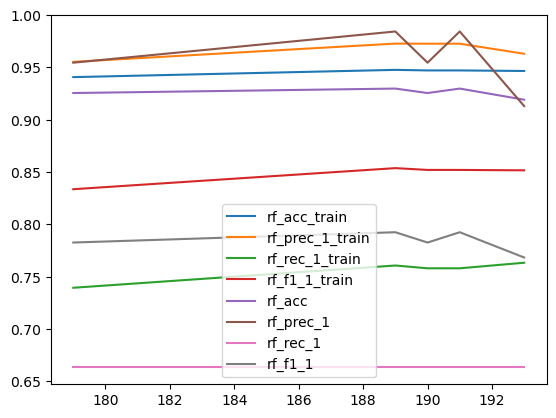

In [30]:
new_stats[new_stats.rf_rec_1 > new_stats.rf_rec_1.max()-0.01][['rf_acc_train', 'rf_prec_1_train', 'rf_rec_1_train', 'rf_f1_1_train', 'rf_acc', 'rf_prec_1', 'rf_rec_1', 'rf_f1_1']].plot()
new_stats[new_stats.rf_rec_1 > new_stats.rf_rec_1.max()-0.01].sort_values(by=['rf_rec_1', 'rf_f1_1', 'rf_prec_1', 'rf_acc', 'rf_f1_1_train', 'rf_prec_1_train', 'rf_rec_1_train', 'rf_acc_train', 'prev_index'], ascending=False)#.head(10)

In [32]:
def hyperp_tuning(X, y):
    params = {'bootstrap': [False, True], #True
            'criterion':['gini', 'log_loss'], #, 'log_loss'
    'max_depth': [4, 5, 6, 7, 8, 10, 12], #, 10, 40, 50, 60    , 30, None
    'max_features': ['log2', 'sqrt', None],  #, 'sqrt', None
    #  'min_samples_leaf': [1, 2, 4],
    #  'min_samples_split': [2, 5, 10], #10, 5
    'n_estimators': [300, 400, 500, 600, 700]} #, 1200, 2000, 1000, 1600     200, 600, 800,200, 400, 

    rf = RandomForestClassifier(random_state=42, class_weight="balanced")
    grid_search = GridSearchCV(estimator = rf, param_grid = params, cv = 3, n_jobs = -1, verbose = 2, refit='recall')
    grid_search.fit(X, y)
    return grid_search

new_feats = new_stats.iloc[191].features
grid_search = hyperp_tuning(X_data[new_feats], y_data)
pd.DataFrame.from_dict(grid_search.cv_results_).sort_values('mean_test_score', ascending=False)

Fitting 3 folds for each of 420 candidates, totalling 1260 fits


c:\Users\YKlysa\AppData\Local\anaconda3\envs\weather\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_bootstrap,param_criterion,param_max_depth,param_max_features,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
91,6.655058,0.116765,0.127216,0.007871,False,gini,12,log2,400,"{'bootstrap': False, 'criterion': 'gini', 'max...",0.916773,0.912932,0.911652,0.913786,0.002176,1
93,10.020590,0.118038,0.188997,0.003509,False,gini,12,log2,600,"{'bootstrap': False, 'criterion': 'gini', 'max...",0.915493,0.911652,0.912932,0.913359,0.001597,2
199,13.931440,0.295151,0.216866,0.007804,False,log_loss,12,log2,700,"{'bootstrap': False, 'criterion': 'log_loss', ...",0.912932,0.912932,0.914213,0.913359,0.000604,2
90,5.030781,0.059365,0.098443,0.001347,False,gini,12,log2,300,"{'bootstrap': False, 'criterion': 'gini', 'max...",0.915493,0.912932,0.911652,0.913359,0.001597,4
198,12.050322,0.213705,0.192795,0.007116,False,log_loss,12,log2,600,"{'bootstrap': False, 'criterion': 'log_loss', ...",0.912932,0.914213,0.911652,0.912932,0.001045,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,14.603457,0.123332,0.068318,0.003937,False,log_loss,4,None,300,"{'bootstrap': False, 'criterion': 'log_loss', ...",0.759283,0.781050,0.869398,0.803244,0.047615,415
116,19.652548,0.279268,0.091087,0.000405,False,log_loss,4,None,400,"{'bootstrap': False, 'criterion': 'log_loss', ...",0.759283,0.781050,0.869398,0.803244,0.047615,415
117,24.766289,0.495110,0.111950,0.000322,False,log_loss,4,None,500,"{'bootstrap': False, 'criterion': 'log_loss', ...",0.759283,0.781050,0.869398,0.803244,0.047615,415
118,29.167599,0.878196,0.165791,0.027934,False,log_loss,4,None,600,"{'bootstrap': False, 'criterion': 'log_loss', ...",0.759283,0.781050,0.869398,0.803244,0.047615,415


In [33]:
grid_search.best_params_

{'bootstrap': False,
 'criterion': 'gini',
 'max_depth': 12,
 'max_features': 'log2',
 'n_estimators': 400}

In [35]:
rf_after_grid = RandomForestClassifier(random_state=42, class_weight="balanced", **grid_search.best_params_)
rf_after_grid.fit(X_data[new_feats], y_data)
y_predict = rf_after_grid.predict(X_test[new_feats])
accuracy = accuracy_score(y_test, y_predict)
print("Accuracy:", accuracy)

conf_matrix = confusion_matrix(y_test, y_predict)
print("Confusion Matrix:")
print(conf_matrix)

class_report = classification_report(y_test, y_predict)
print("Classification Report:")
print(class_report)

c:\Users\YKlysa\AppData\Local\anaconda3\envs\weather\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Accuracy: 0.9233716475095786
Confusion Matrix:
[[206   2]
 [ 18  35]]
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.99      0.95       208
           1       0.95      0.66      0.78        53

    accuracy                           0.92       261
   macro avg       0.93      0.83      0.87       261
weighted avg       0.92      0.92      0.92       261



# Reuse model

In [36]:
model_pkl_file = "rf_trained_step30_after_grid_on_lat_points_inv.pkl" 

# with open(model_pkl_file, 'wb') as file:  
#     pickle.dump(rf_after_grid, file)